In [6]:
import matplotlib.pyplot as plt
import numpy as np

In [7]:
def run(resolution, radius, ionic_strength):
    # cargo run --release -- potential -1 assets/cppm-p18.xyz -a assets/atoms.yml --radius 22 -r 0.1 -M 0.0
    cmd = f"/Users/mikael/github/faunus-rs/target/release/anglescan potential -1 ../assets/cppm-p18.xyz -a ../assets/atoms.yml --radius {radius} -r {resolution} -M {ionic_strength}"
    !{cmd}

 INFO  anglescan > Requested 1257 points on a sphere; got 1442 -> new resolution = 0.09
 INFO  anglescan > Requested 1257 points on a sphere; got 1442 -> new resolution = 0.09
 INFO  anglescan > Requested 1257 points on a sphere; got 1442 -> new resolution = 0.09
 INFO  anglescan > Requested 1257 points on a sphere; got 1442 -> new resolution = 0.09
 INFO  anglescan > Requested 1257 points on a sphere; got 1442 -> new resolution = 0.09
 INFO  anglescan > Requested 1257 points on a sphere; got 1442 -> new resolution = 0.09
 INFO  anglescan > Requested 1257 points on a sphere; got 1442 -> new resolution = 0.09
 INFO  anglescan > Requested 1257 points on a sphere; got 1442 -> new resolution = 0.09
 INFO  anglescan > Requested 1257 points on a sphere; got 1442 -> new resolution = 0.09
 INFO  anglescan > Requested 1257 points on a sphere; got 1442 -> new resolution = 0.09
 INFO  anglescan > Requested 1257 points on a sphere; got 1442 -> new resolution = 0.09
 INFO  anglescan > Requested 125

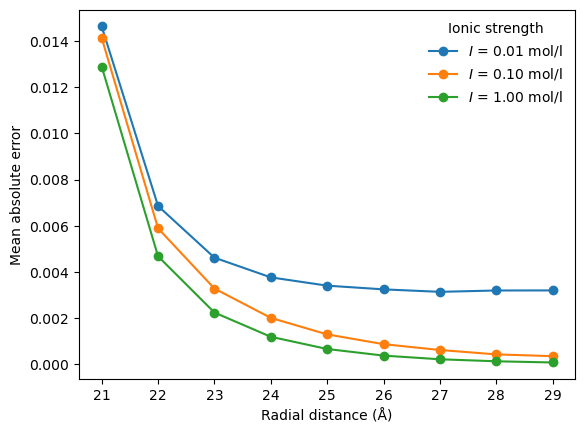

In [149]:
resolution = 0.1
radii = np.arange(21.0, 30, 1.0)
for ionic_strength in [0.01, 0.1, 1.0]:
    abserrors = []
    for radius in radii:
        run(resolution, radius, ionic_strength)
        theta, phi, interpolated, exact, relerr = np.loadtxt("pot_at_angles.dat", unpack=True)
        abserr = np.abs((exact - interpolated))
        abserrors.append(abserr.mean())

        results, edges = np.histogram(abserr, density=True, bins=50)
        binWidth = edges[1] - edges[0]
        # plt.bar(edges[:-1], results*binWidth, binWidth, alpha=0.5, label=f"R = {radius:.1f}")
        # plt.xscale("log")

    plt.plot(radii, abserrors, "o-", label=f"$I$ = {ionic_strength:.2f} mol/l")
plt.xlabel("Radial distance (Å)")
plt.ylabel("Mean absolute error")
plt.legend(loc=0, frameon=False, title="Ionic strength")
plt.savefig("abserr_vs_radius.pdf", bbox_inches="tight")

# Dipole in an electric field

In [8]:
lB = 7.0 # Bjerrum length in Å

def iondipole(r: np.ndarray, q: float, mu: float) -> np.ndarray:
    ''' Exact angularly averaged ion-dipole free energy '''
    field = -lB * q / r**2
    return -np.log(np.sinh(mu*field) / (mu*field))

def iondipole_approx(r: np.ndarray, q: float, mu: float) -> np.ndarray:
    ''' Approximate angularly averaged ion-dipole free energy '''
    return -(lB * mu* q)**2 / (6.0 * r**4)

def run_dipole(resolution: float, mu):
    cmd = f"/Users/mikael/github/faunus-rs/target/release/anglescan dipole --rmin 1.0 --rmax 10.0 --dr 0.2 -m {mu} --output ion-dipole_res{resolution}.dat -r {resolution}"
    !{cmd}

In [14]:
mu = 2.0 # Dipole moment scalar
q = 1.0  # Charge for generating a field
resolutions = [0.05, 0.09, 0.28, 0.55, 1.02]
abs_errs = []
rel_errs = []
abs_errs_interpolated = []
rel_errs_interpolated = []
for res in resolutions:
    run_dipole(res, mu)
    r, w, exact, interpolated = np.loadtxt(f"ion-dipole_res{res}.dat", unpack=True)
    abs_errs.append(np.abs((exact - w)).mean())
    rel_errs.append(np.abs((exact - w) / exact).mean())
    abs_errs_interpolated.append(np.abs((exact - interpolated)).mean())
    rel_errs_interpolated.append(np.abs((exact - interpolated) / exact).mean())

 INFO  anglescan > Requested 5027 points on a sphere; got 5292 -> new resolution = 0.05
 INFO  anglescan > Requested 1551 points on a sphere; got 1692 -> new resolution = 0.09
 INFO  anglescan > Requested 160 points on a sphere; got 162 -> new resolution = 0.28
 INFO  anglescan > Requested 42 points on a sphere; got 42 -> new resolution = 0.55
 INFO  anglescan > Requested 12 points on a sphere; got 12 -> new resolution = 1.02


Mean absolute error: 0.0001277777777777884
Mean relative error: 1.9272889413315313e-05


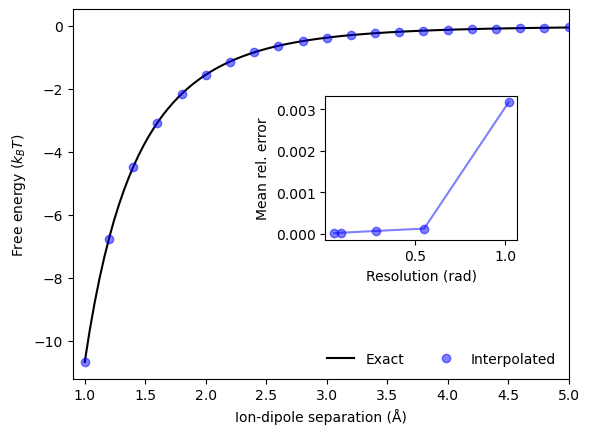

In [27]:
fig, ax1 = plt.subplots()
# These are in unitless percentages of the figure size. (0,0 is bottom left)
left, bottom, width, height = [0.52, 0.4, 0.3, 0.3]
ax2 = fig.add_axes([left, bottom, width, height])

r = np.linspace(1, 5, 100)
ax1.plot(r, iondipole(r, q, mu), 'k-', label="Exact")
# plt.plot(r, iondipole_approx(r, q, mu), "--", label="Approx")

res = 0.05
r, w, exact, interpolated = np.loadtxt(f"ion-dipole_res{res}.dat", unpack=True)
# ax1.plot(r, w, 'bo', label="Vertex sum", alpha=0.5, ms=8)
ax1.plot(r, interpolated, 'bo', label=r"Interpolated", alpha=0.5)
ax1.set_xlim(1-0.1, 5)
ax1.legend(loc=0, frameon=False, ncol=2)
ax1.set_xlabel("Ion-dipole separation (Å)")
ax1.set_ylabel("Free energy ($k_BT$)")

# inset
ax2.set_xlabel("Resolution (rad)")
ax2.set_ylabel("Mean rel. error")
ax2.set_yscale("log")
ax2.plot(resolutions, rel_errs, "bo-", label='Vertex sum', alpha=0.5)
# ax2.plot(resolutions, rel_errs_interpolated, "rs-", label=r"Interpolation", alpha=0.5)

fig.savefig("ion-dipole.pdf", bbox_inches="tight")

print("Mean absolute error:", np.abs((exact - w)).mean())
print("Mean relative error:", np.abs((exact - w) / exact).mean())
